In [1]:
from matplotlib import pyplot as plt
from keras.datasets import fashion_mnist
import numpy as np
import pandas as pd
import math

In [8]:
!pip install wandb -qqq
import wandb
wandb.login()

wandb: Currently logged in as: ravindra_kumar (use `wandb login --relogin` to force relogin)


True

In [ ]:
# # 1. Start a W&B run
# wandb.init(project='gpt3')

# # 2. Save model inputs and hyperparameters
# config = wandb.config
# config.learning_rate = 0.01

# # Model training code here ...

# # 3. Log metrics over time to visualize performance
# for i in range (10):
#     wandb.log({"loss": loss})

NameError: ignored

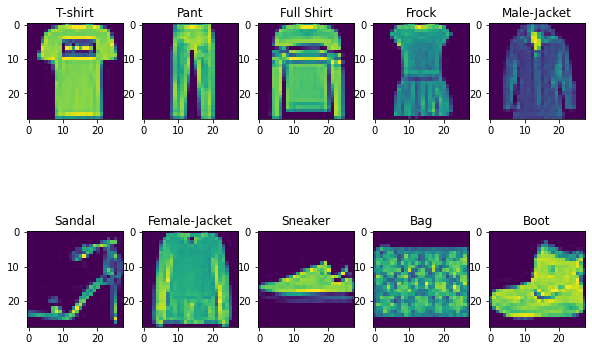

In [ ]:
class_labels = ['T-shirt','Pant','Full Shirt','Frock','Male-Jacket','Sandal','Female-Jacket','Sneaker','Bag','Boot']
(xtrain,ytrain),(xtest,ytest) = fashion_mnist.load_data()
ytrainUnique,uniqueIndex = np.unique(ytrain,return_index=True)
xtrainUnique = xtrain[uniqueIndex] 
fig = plt.figure(figsize=(10, 7));
for i in range(len(ytrainUnique)):
  fig.add_subplot(2, 5, i+1)
  plt.imshow(xtrainUnique[i])#cmap=plt.cm.binary
  plt.title(class_labels[i])  
plt.show()
# wandb.init(project='DL_Assignment_1',entity='Ravindra kumar')
# wandb.log({"ALL_CLASS":[wandb.Image(xtrainUnique[i],caption=class_labels[i]) for i in range(len(ytrainUnique))]})

In [2]:
def sigmoid(x):
    s = 1/(1+np.exp(-x))
    return s

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0,x)

def softmax(arr):
    arr = arr.astype(np.float128)
    length = len(arr)
    s  = np.zeros(length)
    sum = np.sum(np.exp(arr))
    # for i in range(length):
    #     sum = sum + np.exp(arr[i])      #Correction-double addition step
    for i in range(length):
        s[i] = np.exp(arr[i])/sum
    return s
    
def layer_size(trainX,trainY):
    n_x = trainX[0].shape[0]
    n_y = len(np.unique(trainY))
    return n_x,n_y

#implement mean squared error as output is real number
def mean_squared_error(y_true,y_pred):
    length = y_pred.shape[0]
    sum_error = 0
    for i in range(length):
        sum_error = sum_error + ((y_pred[i] - y_true[i])**2)
    return sum_error/length

def cross_entropy(p,q):
    return -np.log(np.dot(p, q))

def der_sigmoid(x):
    return sigmoid(x)*(1-sigmoid(x))

def der_tanh(x):
    return 1-x**2

def der_relu(x):   #Need to double check it for x = 0
    return (x>0)*1

In [3]:
#Initialize the model’s parameters
def initialize_parameters(n_x, n_h, n_y,value = 'random'):
    np.random.seed(2) # we set up a seed so that output matches
    length = len(n_h)
    W,b = [],[]
    #Weight and bias  784 * 4 * 5 * 10
    if value == 'random':
        W.append(np.random.randn(n_h[0],n_x))
        b.append(np.zeros((n_h[0],1))) #b.append(np.random.randn(n_h[0],1))
        for i in range(0,length-1): 
            W.append(np.random.randn(n_h[i+1],n_h[i]))
            b.append(np.zeros((n_h[i+1],1))) #b.append(np.random.randn(n_h[i+1],1))
        W.append(np.random.randn(n_y,n_h[length-1]))
        b.append(np.zeros((n_y,1))) #b.append(np.random.randn(n_y,1)) 
    
    elif value == 'Xavier':
        W.append(np.random.randn(n_h[0],n_x)*2/np.sqrt(n_h[0]+n_x))
        b.append(np.zeros((n_h[0],1)))
        for i in range(0,length-1):
            W.append(np.random.randn(n_h[i+1],n_h[i])*2/np.sqrt(n_h[i+1]+n_h[i]))
            b.append(np.zeros((n_h[i+1],1)))
        W.append(np.random.randn(n_y,n_h[length-1])*2/np.sqrt(n_y+n_h[length-1]))
        b.append(np.zeros((n_y,1))) 
    
    # parameters_w = [W[i] for i in range(len(W))]
    # parameters_b = [b[i] for i in range(len(b))]
    
    # parameters_w = {i: W[i] for i in range(len(W))}
    # parameters_b = {i: b[i] for i in range(len(b))}
    # print("len(W):",len(W))
    # print("b:",b)
    return W,b

def forward_propagation(X, parameters_w,parameters_b,activation_fun = "sigmoid"): 
    # Retrieve each parameter from the dictionary "parameters" 
    # Implement Forward Propagation to calculate A2
    length = len(parameters_w)
    A,H = [],[]
    A.append(np.dot(parameters_w[0],X)+parameters_b[0])
    if activation_fun == "sigmoid":
       H.append(sigmoid(A[0]))
       for i in range(1,length-1):
           A.append(np.dot(parameters_w[i],H[i-1])+parameters_b[i])
           H.append(sigmoid(A[i]))
    elif activation_fun == "relu":
       H.append(relu(A[0]))
       for i in range(1,length-1):
           A.append(np.dot(parameters_w[i],H[i-1])+parameters_b[i])
           H.append(relu(A[i]))
    elif activation_fun == "tanh":
       H.append(tanh(A[0]))
       for i in range(1,length-1):
           A.append(np.dot(parameters_w[i],H[i-1])+parameters_b[i])
           H.append(tanh(A[i]))
    A.append(np.dot(parameters_w[length-1],H[length-2])+parameters_b[length-1])
    H.append(softmax(A[length-1]))
    cache = [A,H]
    # print("H[length-1]:",H[length-1],"sum(H[length-1])",np.sum(H[length-1]),"cache:",cache)
    return cache

# Implementing backward_propagation
def backward_propagation(parameters_w, cache, X, Y,activation_fun = "sigmoid"): #
    Y_vector = np.zeros((10,1)) #converting true label in the shape of 10 by 1
    Y_vector[Y] = 1
    #chache is list of listi.e. half of the entries is A followed by half of the entries as H
    dW,db = [],[]
    num_activation = len(cache[1]) 
    l_w = len(parameters_w)
    A2 = cache[1][num_activation-1]
    A2 = np.array(A2)
    A2.shape = [10,1]
    delta_a_k = A2-Y_vector 
    #hidden layer
    i = num_activation
    j = 1
    while i>1:
      #gradient w.r.t parameters w and b
         hk_1 = np.array(cache[1][i-2]).reshape(-1,1)
         hk_1.shape = [hk_1.shape[0],1]
         dW.insert(0,np.matmul(delta_a_k,hk_1.T))
         db.insert(0,delta_a_k)
      #compute gradient w.r.t layer below
         dZ1 = np.dot(parameters_w[i-1].T,delta_a_k)
      #compute gradient w.r.t layer below(preactivation)
         if activation_fun == "sigmoid":
            der_activation = der_sigmoid(hk_1)
         elif activation_fun == "tanh":
              der_activation = der_tanh(hk_1)
         elif activation_fun == "relu":
              der_activation = der_relu(hk_1)
         delta_a_k = np.multiply(dZ1,der_activation) #sigmoid as activation function at hidden layer, need to generalize it
         i = i - 1
    #input layer
    dW.insert(0,np.dot(dZ1,X.T))
    db.insert(0,delta_a_k)
    return dW,db


    number of epochs: 5, 10
    number of hidden layers: 3, 4, 5
    size of every hidden layer: 32, 64, 128
    weight decay (L2 regularisation): 0, 0.0005, 0.5
    learning rate: 1e-3, 1 e-4
    optimizer: sgd, momentum, nesterov, rmsprop, adam, nadam
    batch size: 16, 32, 64
    weight initialisation: random, Xavier
    activation functions: sigmoid, tanh, ReLU
    

    Agent Starting Run: 23xfbzl1 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 64
wandb: 	weight_initalisation: Xavier

Syncing run swift-sweep-3 to Weights & Biases (docs).
Sweep page: https://wandb.ai/ravindra_kumar/DL_Assignment_1/sweeps/r5eqclnn

(0.5714732730848793, 81.375)
0.5845079581721955 80.96666666666667


In [ ]:
sweep_config = {
    'name': 'sweep_Final',
    'method': 'random',
    'metric':{'name':'Test_Accuracy','goal':'maximize'},
    'parameters': {
        'epoch' : {'values':[5,10]},#[5,10]
        'num_of_hidden_layers':{'values':[3,4,5]},
        'size_of_hidden_layers':{'values':[16,32,128]},#[32,64,128]
        'learning_rate':{'values':[1e-2, 1e-3,1e-4]},
        'optimizer': {'values':['sgd', 'momentum', 'nesterov', 'rmsprop', 'adam']},
        'batch_size' : {'values':[16,32,64]},
        'weight_initalisation':{'values':['random','Xavier']},
        'activation_function':{'values':['sigmoid','tanh','relu']}
    }
}
sweep_id = wandb.sweep(sweep_config,project='DL_Assignment_1',entity='Ravindra_kumar')
wandb.agent(sweep_id,function=Neural_Network,count = 100)#count = 10

Create sweep with ID: 2edi42ua
Sweep URL: https://wandb.ai/ravindra_kumar/DL_Assignment_1/sweeps/2edi42ua


wandb: Agent Starting Run: 4rkyzko4 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(5.422165957613013, 0.10077083333333334)
val_logloss 5.515017093048744 val_Accuracy 0.09691666666666666
Test_logloss 5.440586720318845 Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1
Test_logloss,5.44059
epoch,5
val_Accuracy,0.09692
val_logloss,5.51502


wandb: Agent Starting Run: votpq8wh with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


(1.1380904781534846, 0.5333333333333333)
val_logloss 1.1343675751197906 val_Accuracy 0.5335833333333333
Test_logloss 1.1506622306115086 Test_Accuracy 0.5245


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.5245
Test_logloss,1.15066
epoch,5
val_Accuracy,0.53358
val_logloss,1.13437


wandb: Agent Starting Run: ee5fwtfp with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: overflow encountered in exp
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,10
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: 5yconjdr with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: Xavier


(0.8978876067227447, 0.7023333333333334)
val_logloss 0.8811498249156378 val_Accuracy 0.7095
Test_logloss 0.9090283062186141 Test_Accuracy 0.6983


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6983
Test_logloss,0.90903
epoch,10
val_Accuracy,0.7095
val_logloss,0.88115


wandb: Agent Starting Run: gzvrjcze with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.2280620472575219, 0.45147916666666665)
val_logloss 1.2159868983825908 val_Accuracy 0.45725
Test_logloss 1.2388730479020418 Test_Accuracy 0.4484


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.4484
Test_logloss,1.23887
epoch,10
val_Accuracy,0.45725
val_logloss,1.21599


wandb: Agent Starting Run: f8ivsqr8 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(2.306064738342222, 0.09945833333333333)
val_logloss 2.305949543445719 val_Accuracy 0.10216666666666667
Test_logloss 2.30604169936216 Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1
Test_logloss,2.30604
epoch,5
val_Accuracy,0.10217
val_logloss,2.30595


wandb: Agent Starting Run: 3uh90b9f with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(3.6737238682509203, 0.10020833333333333)
val_logloss 3.6787460611540768 val_Accuracy 0.09916666666666667
Test_logloss 3.674728950959835 Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1
Test_logloss,3.67473
epoch,10
val_Accuracy,0.09917
val_logloss,3.67875


wandb: Agent Starting Run: 03epw1ks with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(0.7342365035205983, 0.7503333333333333)
val_logloss 0.7303608935690784 val_Accuracy 0.7525
Test_logloss 0.7650471610992797 Test_Accuracy 0.7409


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7409
Test_logloss,0.76505
epoch,10
val_Accuracy,0.7525
val_logloss,0.73036


wandb: Agent Starting Run: fub54eyb with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(1.812352369477717, 0.3258125)
val_logloss 1.8051651023637112 val_Accuracy 0.327
Test_logloss 1.8184998295002723 Test_Accuracy 0.3255


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.3255
Test_logloss,1.8185
epoch,5
val_Accuracy,0.327
val_logloss,1.80517


wandb: Agent Starting Run: hb2p9vu2 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(1.1401418650186486, 0.5709375)
val_logloss 1.1247912959960338 val_Accuracy 0.5745
Test_logloss 1.1642014603025121 Test_Accuracy 0.5647


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.5647
Test_logloss,1.1642
epoch,10
val_Accuracy,0.5745
val_logloss,1.12479


wandb: Agent Starting Run: n931reth with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(2.345037308551788, 0.3321458333333333)
val_logloss 2.3490311899441654 val_Accuracy 0.3319166666666667
Test_logloss 2.3386696801952094 Test_Accuracy 0.3294


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.3294
Test_logloss,2.33867
epoch,10
val_Accuracy,0.33192
val_logloss,2.34903


wandb: Agent Starting Run: qmatuz14 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(2.498290850636804, 0.09979166666666667)
val_logloss 2.5021865107691483 val_Accuracy 0.10083333333333333
Test_logloss 2.4990699827156493 Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1
Test_logloss,2.49907
epoch,5
val_Accuracy,0.10083
val_logloss,2.50219


wandb: Agent Starting Run: vlkfn4d1 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(2.0956263936101474, 0.27495833333333336)
val_logloss 2.0945864651925543 val_Accuracy 0.27858333333333335
Test_logloss 2.096037584000608 Test_Accuracy 0.2744


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.2744
Test_logloss,2.09604
epoch,10
val_Accuracy,0.27858
val_logloss,2.09459


wandb: Agent Starting Run: vzsh0j97 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,5
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: 82a2uvtl with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(0.5163488371181981, 0.8224791666666667)
val_logloss 0.5319751769919505 val_Accuracy 0.8175833333333333
Test_logloss 0.5733609304898931 Test_Accuracy 0.8086


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.8086
Test_logloss,0.57336
epoch,10
val_Accuracy,0.81758
val_logloss,0.53198


wandb: Agent Starting Run: q0fp0pob with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(1.5965755576369765, 0.40797916666666667)
val_logloss 1.589200120789182 val_Accuracy 0.41025
Test_logloss 1.5883730493298303 Test_Accuracy 0.4074


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.4074
Test_logloss,1.58837
epoch,10
val_Accuracy,0.41025
val_logloss,1.5892


wandb: Agent Starting Run: w0plgtv8 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(1.0730213498187586, 0.5436875)
val_logloss 1.068337781540038 val_Accuracy 0.5478333333333333
Test_logloss 1.0863647335731474 Test_Accuracy 0.5394


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.5394
Test_logloss,1.08636
epoch,10
val_Accuracy,0.54783
val_logloss,1.06834


wandb: Agent Starting Run: dcboojqr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,5
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: z99pomxl with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,5
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: l3kt19by with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.5097919962882707, 0.35172916666666665)
val_logloss 1.4925934897530253 val_Accuracy 0.3545
Test_logloss 1.5097531450726422 Test_Accuracy 0.3482


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.3482
Test_logloss,1.50975
epoch,10
val_Accuracy,0.3545
val_logloss,1.49259


wandb: Agent Starting Run: wmthbv3i with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: Xavier


(0.8433795177191619, 0.6851041666666666)
val_logloss 0.828685081855641 val_Accuracy 0.6881666666666667
Test_logloss 0.870146211288787 Test_Accuracy 0.6759


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6759
Test_logloss,0.87015
epoch,10
val_Accuracy,0.68817
val_logloss,0.82869


wandb: Agent Starting Run: vmjaphm6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(0.6285258416053388, 0.7836041666666667)
val_logloss 0.6307590756934619 val_Accuracy 0.7781666666666667
Test_logloss 0.6512737067985483 Test_Accuracy 0.7732


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7732
Test_logloss,0.65127
epoch,5
val_Accuracy,0.77817
val_logloss,0.63076


wandb: Agent Starting Run: iaj6h008 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: Xavier


(2.2824639030367626, 0.09960416666666666)
val_logloss 2.2789037406668444 val_Accuracy 0.10158333333333333
Test_logloss 2.2824172715808673 Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1
Test_logloss,2.28242
epoch,5
val_Accuracy,0.10158
val_logloss,2.2789


wandb: Agent Starting Run: 739mahau with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,5
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: d5pahy5u with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(1.052627852161356, 0.6242291666666666)
val_logloss 1.0424984755741407 val_Accuracy 0.6281666666666667
Test_logloss 1.0661927646913916 Test_Accuracy 0.6209


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6209
Test_logloss,1.06619
epoch,5
val_Accuracy,0.62817
val_logloss,1.0425


wandb: Agent Starting Run: 28x1dkwn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(0.6195672725646488, 0.775875)
val_logloss 0.6142802959503051 val_Accuracy 0.7783333333333333
Test_logloss 0.6404102978922037 Test_Accuracy 0.7664


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7664
Test_logloss,0.64041
epoch,10
val_Accuracy,0.77833
val_logloss,0.61428


wandb: Agent Starting Run: bklzbhmk with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(1.38253191500121, 0.38316666666666666)
val_logloss 1.370789514196988 val_Accuracy 0.39058333333333334
Test_logloss 1.3835935578761567 Test_Accuracy 0.3835


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.3835
Test_logloss,1.38359
epoch,10
val_Accuracy,0.39058
val_logloss,1.37079


wandb: Agent Starting Run: uc3184it with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.1586239068406294, 0.56775)
val_logloss 1.1582640986773471 val_Accuracy 0.56675
Test_logloss 1.1995654177792414 Test_Accuracy 0.5529


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.5529
Test_logloss,1.19957
epoch,5
val_Accuracy,0.56675
val_logloss,1.15826


wandb: Agent Starting Run: 8givuvsc with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(0.5743499158823333, 0.80675)
val_logloss 0.5831498711339542 val_Accuracy 0.801
Test_logloss 0.6122961702029199 Test_Accuracy 0.7932


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7932
Test_logloss,0.6123
epoch,10
val_Accuracy,0.801
val_logloss,0.58315


wandb: Agent Starting Run: imdi62ir with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(0.8477064834621519, 0.685625)
val_logloss 0.8349715046716751 val_Accuracy 0.6850833333333334
Test_logloss 0.865975796610868 Test_Accuracy 0.6679


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6679
Test_logloss,0.86598
epoch,5
val_Accuracy,0.68508
val_logloss,0.83497


wandb: Agent Starting Run: 5zyfd96d with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.9751418721603091, 0.222625)
val_logloss 1.9771484279311269 val_Accuracy 0.21633333333333332
Test_logloss 1.975727631869071 Test_Accuracy 0.2237


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.2237
Test_logloss,1.97573
epoch,5
val_Accuracy,0.21633
val_logloss,1.97715


wandb: Agent Starting Run: 4s279hab with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(1.8310014745502525, 0.14622916666666666)
val_logloss 1.8298298875528571 val_Accuracy 0.14191666666666666
Test_logloss 1.8311866609561618 Test_Accuracy 0.1447


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1447
Test_logloss,1.83119
epoch,5
val_Accuracy,0.14192
val_logloss,1.82983


wandb: Agent Starting Run: 72d9ghq0 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(0.8158321057550405, 0.724875)
val_logloss 0.8222673608959059 val_Accuracy 0.7231666666666666
Test_logloss 0.8520056854218224 Test_Accuracy 0.7147


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7147
Test_logloss,0.85201
epoch,5
val_Accuracy,0.72317
val_logloss,0.82227


wandb: Agent Starting Run: vi5w9rad with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: Xavier


(1.3375850514432797, 0.37233333333333335)
val_logloss 1.3362384086205998 val_Accuracy 0.3655
Test_logloss 1.3456761600068086 Test_Accuracy 0.3675


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.3675
Test_logloss,1.34568
epoch,10
val_Accuracy,0.3655
val_logloss,1.33624


wandb: Agent Starting Run: pytks11x with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: Xavier


(0.7149000605842204, 0.7417083333333333)
val_logloss 0.7130020082517451 val_Accuracy 0.7391666666666666
Test_logloss 0.7467074922344948 Test_Accuracy 0.7311


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7311
Test_logloss,0.74671
epoch,5
val_Accuracy,0.73917
val_logloss,0.713


wandb: Agent Starting Run: 2amq0qa3 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(2.325927796945865, 0.2616041666666667)
val_logloss 2.3229408707239254 val_Accuracy 0.25933333333333336
Test_logloss 2.3275613889553837 Test_Accuracy 0.259


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.259
Test_logloss,2.32756
epoch,5
val_Accuracy,0.25933
val_logloss,2.32294


wandb: Agent Starting Run: zxkmwxv3 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(0.5906491666454005, 0.7993125)
val_logloss 0.5968374143697248 val_Accuracy 0.79625
Test_logloss 0.6182048200097788 Test_Accuracy 0.7934


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7934
Test_logloss,0.6182
epoch,10
val_Accuracy,0.79625
val_logloss,0.59684


wandb: Agent Starting Run: f4uxl0te with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(1.3921733668763094, 0.5307083333333333)
val_logloss 1.378597711794784 val_Accuracy 0.5405
Test_logloss 1.3996416161659324 Test_Accuracy 0.5315


wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)
wandb: Network error (HTTPError), entering retry loop.
wandb: ERROR Error while calling W&B API: Error 1040: Too many connections (<Response [500]>)


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.5315
Test_logloss,1.39964
epoch,5
val_Accuracy,0.5405
val_logloss,1.3786


wandb: Agent Starting Run: o0chxu2b with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: Xavier


(1.9458334825062336, 0.1760625)
val_logloss 1.9434314629243066 val_Accuracy 0.17875
Test_logloss 1.945169866284369 Test_Accuracy 0.1743


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1743
Test_logloss,1.94517
epoch,10
val_Accuracy,0.17875
val_logloss,1.94343


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: qks3v8c7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.0519576990843413, 0.6368125)
val_logloss 1.0383758857900678 val_Accuracy 0.64025
Test_logloss 1.0807365843211298 Test_Accuracy 0.6229


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6229
Test_logloss,1.08074
epoch,10
val_Accuracy,0.64025
val_logloss,1.03838


wandb: Agent Starting Run: rd8smrqf with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,5
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: mvm5dsm2 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(0.8499442775065101, 0.6659791666666667)
val_logloss 0.8454041853220857 val_Accuracy 0.66475
Test_logloss 0.888534060817951 Test_Accuracy 0.6474


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6474
Test_logloss,0.88853
epoch,5
val_Accuracy,0.66475
val_logloss,0.8454


wandb: Agent Starting Run: m8r2rpc6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,5
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: qdgpwkwq with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(1.862735344252405, 0.27070833333333333)
val_logloss 1.8520349902466404 val_Accuracy 0.27491666666666664
Test_logloss 1.8735248812648726 Test_Accuracy 0.2683


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.2683
Test_logloss,1.87352
epoch,5
val_Accuracy,0.27492
val_logloss,1.85203


wandb: Agent Starting Run: g2m3ixal with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(0.5350720930860887, 0.8118958333333334)
val_logloss 0.5529143393496084 val_Accuracy 0.802
Test_logloss 0.5758107655008282 Test_Accuracy 0.7986


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7986
Test_logloss,0.57581
epoch,10
val_Accuracy,0.802
val_logloss,0.55291


wandb: Agent Starting Run: ughvjafj with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,5
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: jxvt3q7c with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(2.4330457018058254, 0.0996875)
val_logloss 2.4324643259096335 val_Accuracy 0.10125
Test_logloss 2.4329156517856303 Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1
Test_logloss,2.43292
epoch,5
val_Accuracy,0.10125
val_logloss,2.43246


wandb: Agent Starting Run: 4q47e816 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(0.6816462192075925, 0.7693333333333333)
val_logloss 0.6805234290283603 val_Accuracy 0.7638333333333334
Test_logloss 0.7050630398052619 Test_Accuracy 0.7541


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7541
Test_logloss,0.70506
epoch,10
val_Accuracy,0.76383
val_logloss,0.68052


wandb: Agent Starting Run: yvoxm6kl with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(1.332004839855962, 0.4984375)
val_logloss 1.3304520452271973 val_Accuracy 0.5030833333333333
Test_logloss 1.347146560776226 Test_Accuracy 0.4961


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.4961
Test_logloss,1.34715
epoch,5
val_Accuracy,0.50308
val_logloss,1.33045


wandb: Agent Starting Run: h1ibd2lh with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: RuntimeWarning: divide by zero encountered in log


(nan, 0.6442083333333334)
val_logloss nan val_Accuracy 0.6434166666666666
Test_logloss nan Test_Accuracy 0.6439


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.6439
Test_logloss,nan
epoch,10
val_Accuracy,0.64342
val_logloss,nan


wandb: Agent Starting Run: a915falo with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(2.3082478812496867, 0.09964583333333334)
val_logloss 2.3058046326221566 val_Accuracy 0.10258333333333333
Test_logloss 2.3203373182246727 Test_Accuracy 0.1001


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1001
Test_logloss,2.32034
epoch,5
val_Accuracy,0.10258
val_logloss,2.3058


wandb: Agent Starting Run: s96098ns with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,5
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: cg68d02c with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(1.0504249731122604, 0.6144583333333333)
val_logloss 1.0665141445619104 val_Accuracy 0.6120833333333333
Test_logloss 1.0861681807325372 Test_Accuracy 0.6063


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6063
Test_logloss,1.08617
epoch,10
val_Accuracy,0.61208
val_logloss,1.06651


wandb: Agent Starting Run: 2p0wwlyg with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: Xavier


(0.7341172659834403, 0.755)
val_logloss 0.7294506191023641 val_Accuracy 0.7574166666666666
Test_logloss 0.7561059075826032 Test_Accuracy 0.7463


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7463
Test_logloss,0.75611
epoch,10
val_Accuracy,0.75742
val_logloss,0.72945


wandb: Agent Starting Run: k2v9jjin with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(3.194798633999754, 0.19889583333333333)
val_logloss 3.2113724293845536 val_Accuracy 0.19641666666666666
Test_logloss 3.209016798384531 Test_Accuracy 0.1919


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1919
Test_logloss,3.20902
epoch,5
val_Accuracy,0.19642
val_logloss,3.21137


wandb: Agent Starting Run: 474rws5a with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(1.6563851978168445, 0.3408125)
val_logloss 1.6567173783813858 val_Accuracy 0.3393333333333333
Test_logloss 1.6686133634273677 Test_Accuracy 0.3331


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.3331
Test_logloss,1.66861
epoch,5
val_Accuracy,0.33933
val_logloss,1.65672


wandb: Agent Starting Run: xeryxysi with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(0.5867404105450207, 0.7906041666666667)
val_logloss 0.5958775376368057 val_Accuracy 0.7835833333333333
Test_logloss 0.6204595529118004 Test_Accuracy 0.7772


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7772
Test_logloss,0.62046
epoch,5
val_Accuracy,0.78358
val_logloss,0.59588


wandb: Agent Starting Run: 1txpyjwn with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(2.2599632844401287, 0.134125)
val_logloss 2.2549142854502775 val_Accuracy 0.12533333333333332
Test_logloss 2.2638640110580237 Test_Accuracy 0.133


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.133
Test_logloss,2.26386
epoch,5
val_Accuracy,0.12533
val_logloss,2.25491


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ror6n8de with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(1.3347728432581734, 0.3909375)
val_logloss 1.3215156715370855 val_Accuracy 0.39266666666666666
Test_logloss 1.3381461125202807 Test_Accuracy 0.3833


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.3833
Test_logloss,1.33815
epoch,10
val_Accuracy,0.39267
val_logloss,1.32152


wandb: Agent Starting Run: 12oktbl6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(0.8847535772814166, 0.6855625)
val_logloss 0.8715195835577236 val_Accuracy 0.6876666666666666
Test_logloss 0.8914023222641992 Test_Accuracy 0.6812


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6812
Test_logloss,0.8914
epoch,5
val_Accuracy,0.68767
val_logloss,0.87152


wandb: Agent Starting Run: o9lsjr8i with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.7866449380276783, 0.21302083333333333)
val_logloss 1.7895552331207991 val_Accuracy 0.20416666666666666
Test_logloss 1.7915178099752604 Test_Accuracy 0.2127


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.2127
Test_logloss,1.79152
epoch,5
val_Accuracy,0.20417
val_logloss,1.78956


wandb: Agent Starting Run: xy6znywp with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: Xavier


(1.1450422559623676, 0.5516875)
val_logloss 1.1212108570118455 val_Accuracy 0.5574166666666667
Test_logloss 1.1654132577331833 Test_Accuracy 0.5401


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.5401
Test_logloss,1.16541
epoch,5
val_Accuracy,0.55742
val_logloss,1.12121


wandb: Agent Starting Run: xsdq9awt with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.39755923270743, 0.40747916666666667)
val_logloss 1.384317346018471 val_Accuracy 0.4066666666666667
Test_logloss 1.405416630035598 Test_Accuracy 0.4059


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.4059
Test_logloss,1.40542
epoch,10
val_Accuracy,0.40667
val_logloss,1.38432


wandb: Agent Starting Run: 7v2zx5il with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(1.8804343620264183, 0.27479166666666666)
val_logloss 1.8573051870369952 val_Accuracy 0.28008333333333335
Test_logloss 1.8704952306435219 Test_Accuracy 0.2772


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.2772
Test_logloss,1.8705
epoch,10
val_Accuracy,0.28008
val_logloss,1.85731


wandb: Agent Starting Run: 1ctmb90h with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: Xavier


(3.876889673344076, 0.10025)
val_logloss 3.8455305335775725 val_Accuracy 0.09925
Test_logloss 3.8717616805922788 Test_Accuracy 0.1001


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1001
Test_logloss,3.87176
epoch,10
val_Accuracy,0.09925
val_logloss,3.84553


wandb: Agent Starting Run: 7bfixvxe with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(1.3831453374091527, 0.3858958333333333)
val_logloss 1.3871742734340529 val_Accuracy 0.38408333333333333
Test_logloss 1.3971967884209568 Test_Accuracy 0.3825


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.3825
Test_logloss,1.3972
epoch,10
val_Accuracy,0.38408
val_logloss,1.38717


wandb: Agent Starting Run: ks5zxltd with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(0.7542357022443181, 0.7001041666666666)
val_logloss 0.7463216343628968 val_Accuracy 0.7004166666666667
Test_logloss 0.7610493676524148 Test_Accuracy 0.6953


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6953
Test_logloss,0.76105
epoch,5
val_Accuracy,0.70042
val_logloss,0.74632


wandb: Agent Starting Run: 2d6qp0fi with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 32
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.7207713441095736, 0.32766666666666666)
val_logloss 1.7167414591558643 val_Accuracy 0.3358333333333333
Test_logloss 1.7341025404955885 Test_Accuracy 0.3194


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.3194
Test_logloss,1.7341
epoch,10
val_Accuracy,0.33583
val_logloss,1.71674


wandb: Agent Starting Run: hgudxau6 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(1.137797095498317, 0.6148125)
val_logloss 1.12575835713893 val_Accuracy 0.6245
Test_logloss 1.1444938330686052 Test_Accuracy 0.6056


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6056
Test_logloss,1.14449
epoch,10
val_Accuracy,0.6245
val_logloss,1.12576


wandb: Agent Starting Run: c6qnzbl0 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(2.2404309884823475, 0.2879791666666667)
val_logloss 2.256994563686736 val_Accuracy 0.28458333333333335
Test_logloss 2.24542090012107 Test_Accuracy 0.2875


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.2875
Test_logloss,2.24542
epoch,5
val_Accuracy,0.28458
val_logloss,2.25699


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: pclnb7f4 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: nesterov
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: Xavier


(1.7585807902483412, 0.18645833333333334)
val_logloss 1.7586800029010676 val_Accuracy 0.1895
Test_logloss 1.7615706076585382 Test_Accuracy 0.1857


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1857
Test_logloss,1.76157
epoch,10
val_Accuracy,0.1895
val_logloss,1.75868


wandb: Agent Starting Run: 0xt9fkil with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(1.1812174810641356, 0.5220625)
val_logloss 1.1802735720911282 val_Accuracy 0.5214166666666666
Test_logloss 1.1917356358380033 Test_Accuracy 0.5181


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.5181
Test_logloss,1.19174
epoch,5
val_Accuracy,0.52142
val_logloss,1.18027


wandb: Agent Starting Run: 05uly8q2 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(1.3071947729476245, 0.5075208333333333)
val_logloss 1.306938041403725 val_Accuracy 0.50675
Test_logloss 1.3370706548398097 Test_Accuracy 0.498


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.498
Test_logloss,1.33707
epoch,5
val_Accuracy,0.50675
val_logloss,1.30694


wandb: Agent Starting Run: 5gapb2v3 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(1.0133709196753549, 0.6948333333333333)
val_logloss 1.0048472453237762 val_Accuracy 0.6963333333333334
Test_logloss 1.0040437545912375 Test_Accuracy 0.6982


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.6982
Test_logloss,1.00404
epoch,10
val_Accuracy,0.69633
val_logloss,1.00485


wandb: Agent Starting Run: f1iweyt6 with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: rmsprop
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(nan, 0.10152083333333334)
val_logloss nan val_Accuracy 0.09391666666666666
Test_logloss nan Test_Accuracy 0.1


Test_Accuracy,▁
Test_logloss,
epoch,▁
val_Accuracy,▁
val_logloss,
Test_Accuracy,0.1
Test_logloss,nan
epoch,10
val_Accuracy,0.09392
val_logloss,nan


wandb: Agent Starting Run: 58fos8jr with config:
wandb: 	activation_function: relu
wandb: 	batch_size: 32
wandb: 	epoch: 5
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: sgd
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: Xavier


(0.7191715074691634, 0.7401666666666666)
val_logloss 0.7095780577561693 val_Accuracy 0.7408333333333333
Test_logloss 0.7435784590389709 Test_Accuracy 0.7328


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.7328
Test_logloss,0.74358
epoch,5
val_Accuracy,0.74083
val_logloss,0.70958


wandb: Agent Starting Run: 3u5rhbuj with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.01
wandb: 	num_of_hidden_layers: 3
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.8924380221704973, 0.2026875)
val_logloss 1.8903164166476012 val_Accuracy 0.19616666666666666
Test_logloss 1.8921168877020296 Test_Accuracy 0.2018


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.2018
Test_logloss,1.89212
epoch,10
val_Accuracy,0.19617
val_logloss,1.89032


wandb: Agent Starting Run: 03hqlz05 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 5
wandb: 	learning_rate: 0.0001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 32
wandb: 	weight_initalisation: random


(2.541094512055433, 0.13810416666666667)
val_logloss 2.548584696409797 val_Accuracy 0.13558333333333333
Test_logloss 2.542991005493301 Test_Accuracy 0.1359


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.1359
Test_logloss,2.54299
epoch,5
val_Accuracy,0.13558
val_logloss,2.54858


wandb: Agent Starting Run: 6kzmoymd with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 128
wandb: 	weight_initalisation: random


(2.820094745860011, 0.47929166666666667)
val_logloss 2.827639572894418 val_Accuracy 0.4811666666666667
Test_logloss 2.8565507766677336 Test_Accuracy 0.4718


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.4718
Test_logloss,2.85655
epoch,10
val_Accuracy,0.48117
val_logloss,2.82764


wandb: Agent Starting Run: ud24koa9 with config:
wandb: 	activation_function: sigmoid
wandb: 	batch_size: 16
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 4
wandb: 	optimizer: momentum
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


(1.7053811647433137, 0.257125)
val_logloss 1.7045223758748114 val_Accuracy 0.25133333333333335
Test_logloss 1.7067151097522262 Test_Accuracy 0.2533


Test_Accuracy,▁
Test_logloss,▁
epoch,▁
val_Accuracy,▁
val_logloss,▁
Test_Accuracy,0.2533
Test_logloss,1.70672
epoch,10
val_Accuracy,0.25133
val_logloss,1.70452


wandb: Agent Starting Run: 24ccxwg7 with config:
wandb: 	activation_function: tanh
wandb: 	batch_size: 64
wandb: 	epoch: 10
wandb: 	learning_rate: 0.001
wandb: 	num_of_hidden_layers: 5
wandb: 	optimizer: adam
wandb: 	size_of_hidden_layers: 16
wandb: 	weight_initalisation: random


In [11]:
def Neural_Network(config = None):
    test = True
    # config = {
    # 'epoch':2,
    # 'num_of_hidden_layers':3,
    # 'size_of_hidden_layers':32,
    # 'learning_rate':1e-3,
    # 'optimizer':'sgd',
    # 'batch_size':32,
    # 'weight_initalisation':'random',
    # 'activation_function':'relu'
    # }
    wandb.init(config = config)
    config = wandb.config
    wandb.run.name =config['optimizer']+'_'+config['activation_function']+'_bs_'+str(config['batch_size'])+'_'+config['weight_initalisation']+'_i_'+str(config['epoch'])+'_nh_'+str(config['num_of_hidden_layers'])+'_hl_'+str(config['size_of_hidden_layers'])+'_eta_'+str(config['learning_rate'])
    epoch = config['epoch']
    num_of_hidden_layers = config['num_of_hidden_layers']
    size_of_hidden_layers = config['size_of_hidden_layers']
    learning_rate = config['learning_rate']
    optimizer = config['optimizer']  #sgd, momentum, nesterov, rmsprop, adam,
    batch_size = config['batch_size']
    weight_initialization = config['weight_initalisation'] #random,Xavier
    activation_fun = config['activation_function']  #sigmoid, tanh, relu
    
    # load dataset
    n_h = [size_of_hidden_layers]*num_of_hidden_layers # for i in range(num_of_hidden_layers)]
    (trainX, trainY), (testX, testY) = fashion_mnist.load_data()
    
    np.random.seed(3)
    n = trainX.shape[0]
    perm = list(np.random.permutation(n))
    trainX = trainX[perm,:]
    trainY = trainY.reshape(trainY.shape[0],1)[perm,:]

    # reshape dataset to have a single channel
    X = trainX.reshape((trainX.shape[0], 784, 1))/255.0
    
    numofDataPoints = int(X.shape[0]-(X.shape[0]*0.2))
    # print(numofDataPoints)
    trainX = X[:numofDataPoints]
    valX = X[numofDataPoints:]
    Y = trainY.reshape(-1,1)
    trainY = Y[:numofDataPoints].reshape(-1,1)
    valY = Y[numofDataPoints:].reshape(-1,1)
    # print(valX.shape,valY.shape)
    # print(trainX.shape,trainY.shape)



    if optimizer == 'sgd':
        parameters_w,parameters_b =sgd(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    elif optimizer == 'momentum':
        parameters_w,parameters_b =momentum_gd(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    elif optimizer == 'nesterov':
        parameters_w,parameters_b =nestrov_gd(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    elif optimizer == 'rmsprop':
        parameters_w,parameters_b =rmsprop(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    elif optimizer == 'adam':
        parameters_w,parameters_b =adam(trainX,trainY,n_h,epoch,learning_rate,batch_size,activation_fun,weight_initialization)
    y_hat = predict(trainX,parameters_w,parameters_b,activation_fun)
    # print(y_hat[0],np.sum(y_hat[0]),len(y_hat),np.argmax(y_hat[0]))
    print(accuracy_cal(trainY,y_hat))
    y_hat = predict(valX,parameters_w,parameters_b,activation_fun)
    logerror,accuracy=accuracy_cal(valY,y_hat)
    print('val_logloss',logerror,'val_Accuracy',accuracy)
    wandb.log({'val_logloss':logerror,'val_Accuracy':accuracy,'epoch':epoch})

    if test:
        testX = testX.reshape((testX.shape[0], 784, 1))/255.0
        y_hat = predict(testX,parameters_w,parameters_b,activation_fun)
        logerror,accuracy=accuracy_cal(testY,y_hat)
        print('Test_logloss',logerror,'Test_Accuracy',accuracy)
        wandb.log({'Test_logloss':logerror,'Test_Accuracy':accuracy})


# Neural_Network()

In [5]:
def predict(X,parameters_w,parameters_b,activation_fun):
    y_hat=[]
    for x in X:
        y_hat.append(forward_propagation(x, parameters_w,parameters_b,activation_fun)[1][-1])
    return y_hat
# from sklearn.metrics import accuracy_score
def accuracy_cal(y,y_hat):
    error = 0
    accuracy = 0
    for i in range(len(y)):
        Y_vector = np.zeros((10,1)) #converting true label in the shape of 10 by 1
        Y_vector[y[i]] = 1
        error += cross_entropy(y_hat[i],Y_vector)
        if(np.argmax(y_hat[i]) == y[i]):
            accuracy +=1
    error = error/len(y)
    accuracy = accuracy/len(y)
    return error.item(),accuracy


In [6]:
#****Neural Network method***********#
def sgd(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random'): 
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    for i in range(0, epoch):
        x_count = 0
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            grad_w,grad_b = backward_propagation(parameters_w, cache, x, y,activation_fun) 
            # Gradient descent parameter update.
            x_count+=1
            if x_count%batch_size ==0:
                for j in range(len(parameters_w)):
                    parameters_w[j] = parameters_w[j] - learning_rate*grad_w[j]
                    parameters_b[j] = parameters_b[j] - learning_rate*grad_b[j]
                x_count = 0;
    return parameters_w,parameters_b

def momentum_gd(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random',gamma = 0.9): 
    # gamma = 0.9
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    prev_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    prev_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    for itr in range(0, epoch):
        x_count = 0
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            grad_w,grad_b = backward_propagation(parameters_w, cache, x, y,activation_fun)
            x_count+=1
            if x_count%batch_size ==0:
                for i in range(len(parameters_w)):
                    update_w = gamma*prev_w[i] + learning_rate*grad_w[i]
                    update_b = gamma*prev_b[i] + learning_rate*grad_b[i]
                    parameters_w[i] = parameters_w[i] - update_w
                    parameters_b[i] = parameters_b[i] - update_b
                    prev_w[i] = update_w
                    prev_b[i] = update_b  
                x_count = 0
    return parameters_w,parameters_b

def nestrov_gd(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random',gamma = 0.9): 
    prev_w,prev_b = [],[]
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    prev_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    prev_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    for itr in range(0, epoch):
        x_count = 0
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            update_w = [parameters_w[i] - gamma*prev_w[i] for i in range(len(parameters_w))]
            update_b = [parameters_b[i] - gamma*prev_b[i] for i in range(len(parameters_b))]
            grad_w,grad_b = backward_propagation(update_w, cache, x, y,activation_fun)
            x_count+=1
            if x_count%batch_size ==0:
                for i in range(len(parameters_w)):      # Note for batch size version.
                    update_w = gamma*prev_w[i] + learning_rate*grad_w[i]
                    update_b = gamma*prev_b[i] + learning_rate*grad_b[i]
                    parameters_w[i] = parameters_w[i] - update_w
                    parameters_b[i] = parameters_b[i] - update_b
                    prev_w[i] = update_w
                    prev_b[i] = update_b  
                x_count = 0
    return parameters_w,parameters_b

def rmsprop(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random',beta2 = 0.999,eps = 1e-8): 
    # gamma = 0.9
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    v_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    v_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    for itr in range(0, epoch):
        x_count = 0
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            grad_w,grad_b = backward_propagation(parameters_w, cache, x, y,activation_fun)
            x_count+=1
            if x_count%batch_size ==0:
                for i in range(len(parameters_w)):  # for batch version.
                    v_w[i] = beta2 * v_w[i] + (1-beta2)*np.square(grad_w[i])
                    v_b[i] = beta2 * v_b[i] + (1-beta2)*np.square(grad_b[i])
                    parameters_w[i] = parameters_w[i] - (learning_rate/np.sqrt(v_w[i]+eps))*grad_w[i]
                    parameters_b[i] = parameters_b[i] - (learning_rate/np.sqrt(v_b[i]+eps))*grad_b[i]
                x_count = 0
    return parameters_w,parameters_b

def adam(X, Y, n_h, epoch,learning_rate,batch_size = 64,activation_fun="sigmoid",weight_initialization = 'random',beta1 = 0.9,beta2 = 0.999,eps = 1e-8): 
    # gamma = 0.9
    n_x,n_y = layer_size(X,Y)
    parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y,weight_initialization) 
    m_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    m_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    v_w = [np.zeros(parameters_w[i].shape) for i in range(len(parameters_w))]
    v_b = [np.zeros(parameters_b[i].shape) for i in range(len(parameters_b))]
    for itr in range(0, epoch):
        x_count = 0
        for x,y in zip(X,Y):
            cache = forward_propagation(x, parameters_w,parameters_b,activation_fun)
            grad_w,grad_b = backward_propagation(parameters_w, cache, x, y,activation_fun)

            x_count+=1
            if x_count%batch_size ==0:
                for i in range(len(parameters_w)):  # for batch version.
                    m_w[i] = beta1 * m_w[i] + (1-beta1)*grad_w[i]
                    m_b[i] = beta1 * m_b[i] + (1-beta1)*grad_b[i]

                    v_w[i] = beta2 * v_w[i] + (1-beta2)*np.square(grad_w[i])
                    v_b[i] = beta2 * v_b[i] + (1-beta2)*np.square(grad_b[i])

                    m_w_hat = m_w[i]/(1-math.pow(beta1,i+1))
                    m_b_hat = m_b[i]/(1-math.pow(beta1,i+1))
                    v_w_hat = v_w[i]/(1-math.pow(beta2,i+1))
                    v_b_hat = v_b[i]/(1-math.pow(beta2,i+1))

                    parameters_w[i] = parameters_w[i] - (learning_rate/np.sqrt(v_w_hat+eps))*m_w_hat
                    parameters_b[i] = parameters_b[i] - (learning_rate/np.sqrt(v_b_hat+eps))*m_b_hat
                x_count = 0
    return parameters_w,parameters_b

# def mini_batch_gd(X, Y, n_h, epoch,learning_rate,batch_size = 64): 
#     np.random.seed(3)
#     n = X.shape[0]
#     perm = list(np.random.permutation(n))
#     shuffledX = X[perm,:]
#     shuffledY = Y.reshape(Y.shape[0],1)[perm,:]
#     num_batches = math.floor(n/batch_size);
#     n_x,n_y = layer_size(X,Y)
#     parameters_w,parameters_b = initialize_parameters(n_x, n_h, n_y) 
#     for itr in range(0, epoch):
#         for batchnum in range(num_batches):
#             x_batch = shuffledX[batchnum*batch_size:(batchnum+1)*batch_size,:]
#             y_batch = shuffledY[batchnum*batch_size:(batchnum+1)*batch_size,:]
#             for x,y in zip(x_batch,y_batch):
#                 pred_y, cache = forward_propagation(x, parameters_w,parameters_b)
#                 grad_w,grad_b = backward_propagation(parameters_w, cache, x, y) #parameters NOT defined.
#             # Gradient descent parameter update.
#             #parameters = update_parameters(parameters, grads,learning_rate)
#             for i in range(len(parameters_w)):
#                  parameters_w[i] = parameters_w[i] - learning_rate*grad_w[i]
#                  parameters_b[i] = parameters_b[i] - learning_rate*grad_b[i]
#     return parameters_w,parameters_b